# Tree Bark Classifier

This jupyter notebook documents the construction, training, and evaluation of a convolutional neural network (CNN) that identifies trees based on images of bark. We'll use the keras neural network library, which provides a simple interface to tensorflow code.

## Import modules to build a convolutional neural network

In [146]:
## Modules for CNN
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Flatten, Activation, Input, Conv2D, BatchNormalization, 
                                     MaxPooling2D, Dropout, Dense)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K ## Functions for sum, square, abs of tensors
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Sequential

## Modules for miscellaneous (accessing directories, working with arrays, etc)
import numpy as np 
import os
import pandas as pd

## Tree bark dataset

The dataset consists of images of tree bark from over 100 trees which are divided between 14 tree types. I originally wanted to break things down by species throughout, but quickly found I was uncertain about certain ID's. As a result, some of the tree classes are species (red maple, *Acer rubrum*), others are down to genus (Elm, Ulmus). The oaks are broken down to genus and a red or white oaks (e.g., Quercus red). These might be refined later on as my ability to ID trees improves.  

Each tree in the dataset was ID'd, and 16 photographs were taken of the bark. The 16 photographs are comprised of images from ground level to a height of 2 meters, with 4 photos taken from each of 4 sides of the tree. The images are in subdirectories of dataset200. Here, "200" refers to the pixel width of the images; the originals are much larger and were reduced to save memory. Notice that the directories that contain the images are structured into training, validation, and testing datasets:  

- dataset200
    - train
        - *Acer rubrum*
        - *Acer saccharinum*
        - etc.
        
    - val
        - *Acer rubrum*
        - *Acer saccharinum*
        - etc.
    - test (in progress)
        
        
Importantly, for a given tree, all 16 images were placed either in only one of the train, val, or test folders. Images in the train folder will be used to train the model, images in the val folder will be used to select the best model hyperparameters and to evaluate the number of training epochs required. Images in the test folder will be used to rigorously assess the final model. 

#### List the species in the training dataset. Get the number of tree classes as we'll need that later. 

In [147]:
train_image_path = 'dataset200/'
class_list = os.listdir(train_image_path + 'train')
nclasses = len(class_list)
print(class_list)
print('\n')
print(str(nclasses) + ' tree classes in total')

['Acer_saccharum', 'Quercus_white', 'Prunus_serotina', 'Pinus_banksiana', 'Quercus_red', 'Tilia_americana', 'Betula_papyrifera', 'Pinus_resinosa', 'Betula_lutea', 'Acer_saccharinum', 'Ulmus', 'Pinus_strobus', 'Acer_rubrum', 'Fraxinus']


14 tree classes in total


#### Read in and plot a single image

In [148]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

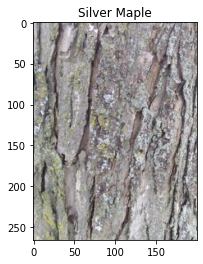

In [149]:
Ex_path = train_image_path + "train/Acer_saccharinum/" 
Ex_list = os.listdir(Ex_path)
Ex_image = mpimg.imread(Ex_path + Ex_list[3])
plt.imshow(Ex_image)
plt.title("Silver Maple")
img_height = Ex_image.shape[0]
img_width = Ex_image.shape[1]

#### Next, plot a few example class images in different rows of a figure grid. 

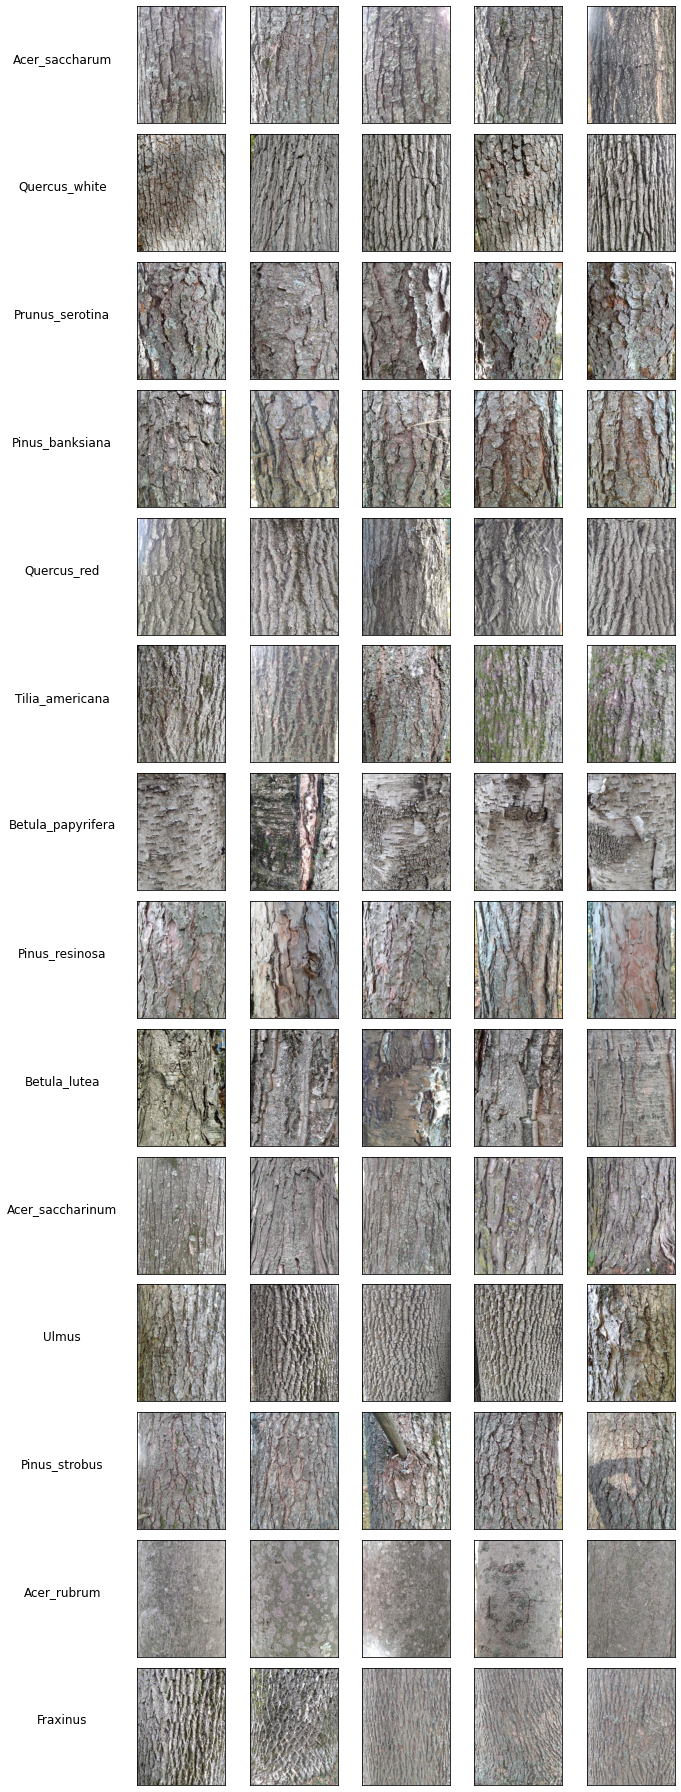

In [150]:
num_examples = 5
fig, axes = plt.subplots(nrows=nclasses, ncols=num_examples, figsize=(10, 25))

rows = ['{}'.format(row) for row in class_list]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, labelpad = 75, rotation=0, size='large')

for class_index in range(nclasses):
    class_name = class_list[class_index]
    Ex_path = train_image_path + "train/" + class_name + '/' 
    Ex_list = os.listdir(Ex_path)
    for ex_image in range(0,num_examples):
        Ex_image = mpimg.imread(Ex_path + Ex_list[ex_image])
        axes[class_index][ex_image].imshow(Ex_image)
        axes[class_index][ex_image].tick_params(axis = 'both', which = 'both', bottom = False, top = False, 
                                                 right = False, left = False, labelbottom = False,
                                                 labelleft = False)
fig.tight_layout()
fig.show()

#### Check whether class imbalances exist in the dataset

{'Acer_saccharum': 32, 'Quercus_white': 32, 'Prunus_serotina': 32, 'Pinus_banksiana': 48, 'Quercus_red': 96, 'Tilia_americana': 32, 'Betula_papyrifera': 32, 'Pinus_resinosa': 96, 'Betula_lutea': 32, 'Acer_saccharinum': 96, 'Ulmus': 32, 'Pinus_strobus': 96, 'Acer_rubrum': 144, 'Fraxinus': 32}


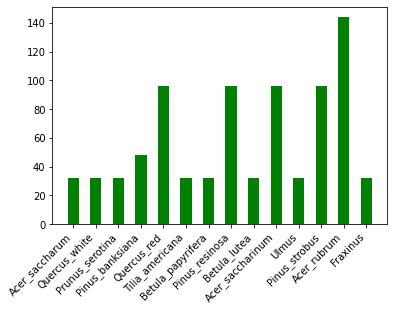

In [151]:
num_images_list = dict()
for class_name in class_list:
    num_images_list[class_name] = len(os.listdir(train_image_path + "train/" + class_name)) 

print(num_images_list)
plt.bar(num_images_list.keys(), num_images_list.values(), 0.5, color='g');
plt.xticks(rotation = 45, ha = 'right');

The number of images in each class are not the same. This is a problem because a model that is naively trained on this dataset will bias its prediction toward the most common class (red maple, *Acer rubrum*). This could be desireable, for example, if I believed that this same distribution of tree class will occur in arbitrary use-cases. However, this is undesireable if a user lives in an area where red maples are rare. 

Initially, I was careful to add tree types so that each of the class sizes would be equal. As I was out in the field collecting images, however, it quickly became clear that a balanced training set will be difficult to maintain. The difficulty arises because certain trees (i.e., red maples) are much more abundant than others in my region. As a result, if I want a balanced training set, any increase to the size of the training dataset is limited by my ability to find new examples of the rarest tree. 

Rather than live with this constraint, I decided to embrace class imbalance and use sample weights to overcome the class imbalance problem. Sample weights determine the extent to which the model learns from each image during the training process. Images that are over-represented have a lower sample weight, and images that are under-represented have a higher sample weight. When chosen properly, we can ensure that each class type will have an equal influence on the bark patterns that the model learns to identify.  

## Data Augmentation

Our training dataset consists of over 800 images. However, our neural network will require hundreds of thousands of images to adjust millions of convolutional filter weights. We'll use data augmentation to inflate the size our dataset. Simply put, this process augments our dataset with random rotations, reflections, and zoomed-in versions of our original dataset. The ImageDataGenerator class generates these augmented images. 

#### Build the data generator for the training dataset

In [152]:
train_path = 'dataset200/train'
batch_size = 64 ## Number of images loaded in per training iteration. 

## Before being fed into the CNN, each image is normalized so that its values 
## fall between -1 and 1. Normalization is not absolutely required, but, 
## is an easy way to increase the speed with which the model learns patterns
## in the dataset. 
def normalize_image(img):
    img = img / 127.5
    img = img - 1.0 
    return (img)

## Here, we construct an ImageDataGenerator object that outputs the augmented
## images. First, we specify that each image should be normalized. 
## After that, we allow rotations of +/- 20 degrees, and magnification of 
## +/- 0.2. Some of these augmentations will result in a smaller image
## or blank space. We use reflection to fill in any blank spaces and keep
## the augmented image size the same. 
train_datagen = ImageDataGenerator(
    preprocessing_function = normalize_image,
    rotation_range = 20,
    shear_range=0.0,
    zoom_range=0.2,
    vertical_flip = False,
    horizontal_flip=True, 
    fill_mode = 'reflect')



#### Construct the generator with class imbalance in mind

We'll use the ImageDataGenerator's flow_from_dataframe class to feed images into the CNN. With this specification, the ImageDataGenerator will be given a dataframe, called train_dataframe in the cell below, whose columns describe image file locations, corresponding classes, and the weight given to each sample. Weights are calculated so that the sum of all weights for a given class add to total_train_images/nclasses.

In [153]:
train_dataframe = pd.DataFrame()
for class_name in class_list:
    image_list = os.listdir(train_path + '/' + class_name)
    num_images = len(image_list)
    for image_file in image_list:
        new_row = {'Image_Name':train_path + '/' + class_name + '/' + image_file, 
                   'Class':class_name, 'Number':num_images}
        train_dataframe = train_dataframe.append(new_row, ignore_index = True)
       
    
total_train_images = train_dataframe.shape[0]   

train_dataframe['Weight_Col'] = total_train_images/(train_dataframe['Number']*nclasses)

In [154]:
train_dataframe

,Class,Image_Name,Number,Weight_Col
0,Acer_saccharum,dataset200/train/Acer_saccharum/IMG_20201004_1...,32.0,1.857143
1,Acer_saccharum,dataset200/train/Acer_saccharum/IMG_20201004_1...,32.0,1.857143
2,Acer_saccharum,dataset200/train/Acer_saccharum/IMG_20201004_1...,32.0,1.857143
3,Acer_saccharum,dataset200/train/Acer_saccharum/IMG_20201004_1...,32.0,1.857143
4,Acer_saccharum,dataset200/train/Acer_saccharum/IMG_20201010_1...,32.0,1.857143
...,...,...,...,...
827,Fraxinus,dataset200/train/Fraxinus/IMG_20201003_1644046...,32.0,1.857143
828,Fraxinus,dataset200/train/Fraxinus/IMG_20201003_1644237...,32.0,1.857143
829,Fraxinus,dataset200/train/Fraxinus/IMG_20201003_1644385...,32.0,1.857143
830,Fraxinus,dataset200/train/Fraxinus/IMG_20201003_1644304...,32.0,1.857143


In [155]:
## Specify that the source image filenames will be organized into a 
## pandas dataframe. The Categorical class mode yields labels that
## are 1D one-hot encoded arrays. We'll train in batches of size 
## 64. 
train_generator = train_datagen.flow_from_dataframe(
    train_dataframe, x_col = 'Image_Name', y_col = 'Class',
    weight_col = 'Weight_Col',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 832 validated image filenames belonging to 14 classes.


#### Data generator for the validation dataset

In [156]:
## The code for the validation ImageDataGenerator is nearly identical. 
## However, note that we do not augment the validation dataset; we only
## normalize the images. 
val_path = 'dataset200/val'

val_dataframe = pd.DataFrame()
for class_name in class_list:
    image_list = os.listdir(val_path + '/' + class_name)
    num_images = len(image_list)
    for image_file in image_list:
        new_row = {'Image_Name':val_path + '/' + class_name + '/' + image_file, 
                   'Class':class_name, 'Number':num_images}
        val_dataframe = train_dataframe.append(new_row, ignore_index = True)

val_datagen = ImageDataGenerator(
    preprocessing_function = normalize_image,    
)

validation_generator = val_datagen.flow_from_dataframe(
    val_dataframe, x_col = 'Image_Name', y_col = 'Class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')        
    
total_val_images = val_dataframe.shape[0]   

Found 833 validated image filenames belonging to 14 classes.


#### Here's an example of our train generator in action

The shape of the image stack is (64, 266, 200, 3)
Left image is Pinus_strobus, and has weight 0.6190476190476191
Right image is Tilia_americana, and has weight 1.8571428571428572


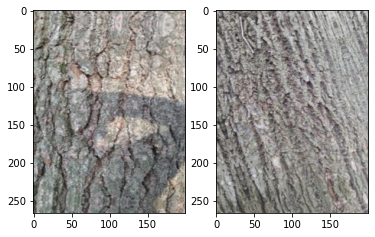

In [157]:
## class_list is how the ImageDataGenerator is associating species 
## type with the one-hot encoding array. 
class_list = list(train_generator.class_indices.keys())

## Grab one batch of images, a one-hot encoded response, and weights. The 
## images are bound together in a stack with depth 64, the batch 
## size we chose in our train_generator. The one-hot encoded 
## array of classes for each of those images is a 2 dimensional 
## array of 0's and 1's. Each row corresponds to one image in 
## the stack, and has a "1" in the corresponding class column
## of the image. 
img_stack, one_hot, weight = next(train_generator)
print("The shape of the image stack is " + str(img_stack.shape)) 

## img_stack is a stack of 64 images (the batch size). Grab the 
## first two images for plotting. 
img1 = img_stack[0,:,:,:]
img2 = img_stack[1,:,:,:]

## Un-normalize the images
img1 = (img1 + 1)*127.5  
img2 = (img2 + 1)*127.5

##plt.imshow(img1/255.0)
##plt.imshow(img2/255.0)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1.astype('int'))
axarr[1].imshow(img2.astype('int'))

print("Left image is " + class_list[one_hot[0].argmax()] + ', and has weight ' + str(weight[0]))
print("Right image is " + class_list[one_hot[1].argmax()] + ', and has weight ' + str(weight[1]))

## Build the CNN model

We will use several layers of the VGG16 convolutional neural network. VGG16 was first proposed in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”, written by K. Simonyan and A. Zisserman from the University of Oxford. This CNN model achieves 92.7% test accuracy in ImageNet, a dataset of over 14 million images belonging to 1000 classes. In that dataset, classes are everyday objects like dog, cat, shoe, car, etc. Here, we use the initial, pretrained convolutional layers of VGG16 to (hopefully) "see" edges, shapes, and other continuous edges of tree bark that may be useful in identification. Those pre-trained convolutional filter weights will then be adjusted to maximize the model's performance on tree bark. 

The following cell defines a function, vgg_bark, that builds the CNN with dropout (a form of regularization) as an option. The top-most layer is built so that the CNN returns 1 probability for each tree class.  

In [158]:
## Function arguments are weights from previous training session, dropout for regularization, 
## learning rate (lr), and the number of tree classes. 
def vgg_bark(input_size, pretrained_weights = None,
             dropout = 0, lr = 1e-3, 
             classes = 14):
    
    ## This layer describes the normalized image input
    input = Input(shape=input_size,name = 'image_input')

    ## This line returns the VGG16 CNN pretrained on the imagenet dataset. 
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_shape=input_size, 
                            input_tensor=input)

    ## The following lines extract the basal convolutional layers of VGG16. These layers, 
    ## in turn, find localized features in the image (corners, edges, etc.) that will 
    ## be useful in identification. In subsequent layers, these features are condensed 
    ## into many transformed, versions of the input image.
    block1_conv2 = model_vgg16_conv.get_layer('block1_conv2').output
    block2_conv2 = model_vgg16_conv.get_layer('block2_conv2').output    
    block3_conv3 = model_vgg16_conv.get_layer('block3_conv3').output
    block4_conv3 = model_vgg16_conv.get_layer('block4_conv3').output
    block5_conv3 = model_vgg16_conv.get_layer('block5_conv3').output
    output_vgg16_conv = model_vgg16_conv.get_layer('block5_pool').output    
    
    ## We add an optional dropout layer, in which a random subset of the image pixels
    ## in the feature maps are dropped. Training a model with dropout can sometimes 
    ## result in more robust feature-detectors to be learned. 
    x = Dropout(rate = dropout)(output_vgg16_conv)  

    ## The above "x" is a 7x7 pixel image. Here, we "flatten" this image into an array 
    ## of values. These values are then connected to a layer of neurons, one for each 
    ## tree species class. With the "softmax" type of activation, the predicted class 
    ## is given by the neuron that is activated the most. 
    x = Flatten(name='flatten')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    ## Define the layers into a graph mapping the inputs to the final layer of classes, x.
    model = Model(inputs = input, outputs = x)
    
    ## Compile the model. Here, we set the optimizer, the learning rate, and the loss function. 
    ## The categorical cross-entropy loss function is essentially the likelihood of observing the 
    ## data, given the probability assigned to the various classes. 
    model.compile(optimizer = Adam(lr = lr),loss=tensorflow.keras.backend.categorical_crossentropy)

    ## Load in pretrained weights if any are given.
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

#### Determine what input shape the CNN model will be expecting

Specify the input shape of images passed to the CNN model. Images can be (width, height, channels), or (channels, width, height). We use the Keras backend object K to determine which shape the CNN will be expecting.

In [159]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)
    
print(K.image_data_format())

channels_last


#### View summary of the model

Below, we use the vgg_bark function to construct a CNN model, and view a summary of the model layers. Below, the Output Shape column describes the transformations that being applied to the input image. Notice that the normalized input image has shape (200,266,3). The first convolutional layer, block1_conv1, grows that image z-dimension into a stack of 64 channels. Each of these feature-maps contain information on where relevant features occur in the original image. 

Convolutional layers are paired with pooling layers, which condense and summarize the feature maps. Pooling slides a window across the image, replacing pixels within the window with the maximum. At the end of the convolutional and pooling steps, the original normalized image has been deformed into a (6, 8, 512) array which is flattened into a vector. 

The flattened vector is passed to a dense layer of neurons that each represent a tree species. The neuron that gets activated the most determines the class that is predicted. 

In [160]:
vgg_model = vgg_bark(input_shape)
vgg_model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 266, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 266, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 266, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 133, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 133, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 133, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 66, 50, 128)       0  

## Train the CNN model

Time to train the model! The cell below is organized so that the user can specify a model name and parameters. The trained model will be saved in the model_weights folder. A trained model can be reloaded for later use or additional training. 

The categorical cross-entropy loss during each training epoch is saved in a csv file in the "logs" directory. This information is crucial to understanding the minimal number of training epochs that are required for a high-performance model. 

In [116]:
batch_size = 64
epochs = 1000
lrb10 = 7 ## -log10(learning rate) - this format goes in the model name
lr = 10**(-lrb10) ## Learning rate
dropouts = [0, 0.1, 0.25]

for dropout in dropouts: ## Float between 0 and 1
    model_name = 'woof_lr' + str(lrb10) + '_bs' + str(batch_size) +  '_do' + str(dropout)
    num_train_images = total_train_images
    num_val_images = total_val_images
    model_checkpoint = ModelCheckpoint('model_weights/' + model_name +".hdf5", monitor='val_loss',verbose=1, 
                                        save_best_only=True)    
    model = vgg_bark(input_size = input_shape, pretrained_weights = None, 
             dropout = dropout, lr = lr)
    model.fit(
        train_generator, 
        steps_per_epoch = num_train_images // batch_size, 
        epochs = epochs, 
        validation_data = validation_generator, 
        validation_steps = num_val_images // batch_size, 
        callbacks=[model_checkpoint])
    history = model.history
    loss_name = "logs/" + model_name + ".csv"
    loss_df = pd.DataFrame(history.history)
    loss_df.to_csv(loss_name)


Epoch 1/1000
13/13 [==============================] - ETA: 0s - loss: 2.7965
Epoch 00001: val_loss improved from inf to 2.72628, saving model to model_weights/woof_lr7_bs64_do0.hdf5
13/13 [==============================] - 13s 995ms/step - loss: 2.7965 - val_loss: 2.7263
Epoch 2/1000
13/13 [==============================] - ETA: 0s - loss: 2.7668
Epoch 00002: val_loss improved from 2.72628 to 2.72238, saving model to model_weights/woof_lr7_bs64_do0.hdf5
13/13 [==============================] - 13s 975ms/step - loss: 2.7668 - val_loss: 2.7224
Epoch 3/1000
13/13 [==============================] - ETA: 0s - loss: 2.7587
Epoch 00003: val_loss improved from 2.72238 to 2.71999, saving model to model_weights/woof_lr7_bs64_do0.hdf5
13/13 [==============================] - 13s 1s/step - loss: 2.7587 - val_loss: 2.7200
Epoch 4/1000
13/13 [==============================] - ETA: 0s - loss: 2.6728
Epoch 00004: val_loss improved from 2.71999 to 2.71644, saving model to model_weights/woof_lr7_bs64_do

## Evaluate the best dropout level

Load in the csv file of training information for each dropout level. 

In [161]:
csv_list = []
for ii in range(len(dropouts)):
    dropout = dropouts[ii]
    model_name = 'woof_lr' + str(lrb10) + '_bs' + str(batch_size) +  '_do' + str(dropout)
    csv_list.append(pd.read_csv('logs/' + model_name + '.csv'))

In [162]:
csv_list[0]

,Unnamed: 0,loss,val_loss
0,0,2.796550,2.726285
1,1,2.766825,2.722383
2,2,2.758675,2.719989
3,3,2.672766,2.716436
4,4,2.848519,2.714597
...,...,...,...
995,995,0.280860,0.402193
996,996,0.270157,0.400959
997,997,0.259128,0.392800
998,998,0.270109,0.391471


Plot the decrease in the training and validation loss. 

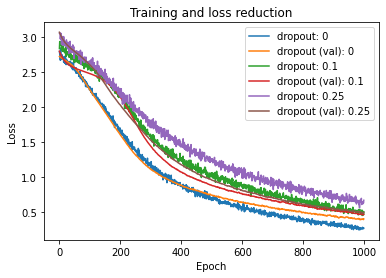

In [163]:
#Plot a line graph
plt.plot(csv_list[0]['loss'], label='dropout: 0')
plt.plot(csv_list[0]['val_loss'], label='dropout (val): 0')

plt.plot(csv_list[1]['loss'], label='dropout: 0.1')
plt.plot(csv_list[1]['val_loss'], '-', label='dropout (val): 0.1')

plt.plot(csv_list[2]['loss'], label='dropout: 0.25')
plt.plot(csv_list[2]['val_loss'], '-', label='dropout (val): 0.25')

# Add labels and title
plt.title("Training and loss reduction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
 
plt.legend()
plt.show()

The graph above shows that the training iterations with dropout set to 0 performed fine. Notice that the training and validation loss values decrease in concert until around epoch 500. However, even after epoch 500, the validation loss continues to decrease. Given that all levels of dropout performed well, we'll choose the model formulation without dropout because it results in the smallest validation loss after 1000 epochs.

## Evaluate model performance

#### Use the trained CNN to predict the validation images

In [164]:
## Load in the CNN model we trained above. 
model_name = 'woof_lr7_bs64_do0'
model = vgg_bark(input_size = input_shape, pretrained_weights = 'model_weights/' + model_name + ".hdf5", 
        dropout = 0, lr = lr)

## We will assess the model's performance on the validation set. 
val_path = train_image_path + "val/"

y_true = []
y_pred = []

## This line gives information on how the array of predictions that are returned
## from our CNN correspond to the different class classes. As we might expect, 
## classes are encoded from 0 - nclasses alphabetically. 
class_list = list(train_generator.class_indices.keys())

for class_name in class_list:
    class_path = val_path + class_name
    image_list = os.listdir(class_path)
    for image_name in image_list:
        image = mpimg.imread(class_path + '/' + image_name)
        ## It's important that we do not forget to normalize the image we are predicting!
        ## In order to make the loaded images input shape that which the model is 
        ## expecting, we then swap the first two indices, and pad with an empty dimension. 
        image = normalize_image(image)
        ##image = image.swapaxes(0,1) 
        image = np.expand_dims(image, 0)
        predicted_class = class_list[model.predict(image).argmax()]
        y_pred.append(predicted_class)
        y_true.append(class_name)

#### Evaluate the overall accuracy of the model predictions

If we had equal sized classes, a completely random model would classify a tree class correctly with probability 1/nclasses = 1/14, or 8% of the images. With imbalanced class sizes, the best "null" strategy is to always choose the class that is most common. If a model chose *Acer rubrum* each time, it would classify correctly with probability 144/832, or 17%. Can our model do better? 

In [165]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", str(accuracy_score(y_true, y_pred)))

Accuracy:  0.5975


60% is not bad! Definitely better than random! However, because our class sizes are imbalanced, accuracy doesn't tell us much about how well the model performed. 

Next, create a confusion matrix that describes the distribution of model predictions for each class. This will give us a better idea of the kinds of errors the model makes when trying to identify each tree class. First, recall the ordering of the tree classes: 

In [166]:
class_list

['Acer_rubrum',
 'Acer_saccharinum',
 'Acer_saccharum',
 'Betula_lutea',
 'Betula_papyrifera',
 'Fraxinus',
 'Pinus_banksiana',
 'Pinus_resinosa',
 'Pinus_strobus',
 'Prunus_serotina',
 'Quercus_red',
 'Quercus_white',
 'Tilia_americana',
 'Ulmus']

In [167]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_true, y_pred, labels = np.asarray(class_list))
conf

array([[70, 26, 12,  9,  5,  3,  2,  0,  1,  1,  4,  3,  5,  3],
       [ 3, 82,  7,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6,  0,  5,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  8,  0,  1,  1,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  8, 22,  0,  1,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  3,  0, 14,  4],
       [ 0,  1,  0,  3,  0,  0, 38,  1,  0,  5,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 78,  0,  1,  0,  0,  0,  0],
       [ 1,  7,  5,  0,  0,  0, 17,  0, 60,  2,  2,  0,  1,  1],
       [ 0,  0,  0,  2,  1,  0, 12,  0,  1, 16,  0,  0,  0,  0],
       [ 1,  1,  7,  0,  0,  2,  4,  0,  6,  0, 66,  2,  6,  1],
       [ 2, 10,  2,  1,  0,  0,  0,  0,  1,  0,  1, 15,  0,  0],
       [ 3,  4,  1,  1,  0,  1,  0,  0,  3,  0,  3,  6,  2,  8],
       [ 4,  1,  4, 10,  0,  0,  3,  0,  1,  0,  6,  1,  1,  1]])

The seaborn package can be used to make a nice plot of the confusion matrix. 

Text(68.09375, 0.5, 'Actual')

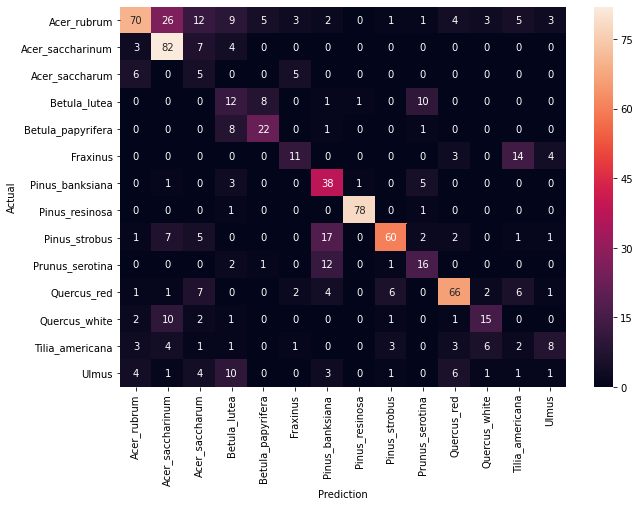

In [168]:
import seaborn as sn
df_cm = pd.DataFrame(conf, index = [i for i in class_list],
                  columns = [i for i in class_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Actual')

Most of the errors in the model come from trees that are truly hard to distinguish by bark alone. From the first row of this heatmap plot, we see that if the model receives an image of *Acer rubrum* (red maple), it sometimes confuses it for an *Acer saccharinum* (silver maple) or *Acer saccharum* (sugar maple). Older red maple bark can certainly look like silver or sugar maple bark, so this is isn't too surprising. In addition, *Prunus serotina* (black cherry) is consistantly confused with *Pinus banksiana* (jack pine). Both have dark bark arranged in scales that peel off the tree. Finally, the birches (Betula) are oftentimes confused for one another. 

More broadly, I see a few classes with low predictive performance that also have a low sample size: *Acer saccharum*, *Betula lutea*, *Fraxinus*, *Tilia americana*, and Quercus (white). Performance on these classes would likely be improved by increasing the number of trees in the dataset. 

Next, look at some other common measures of classification model performance. https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall is a great resource for understanding the classification metrics discussed below.  

#### Recall

Recall measures the proportion of correctly identified instances of a focal class. For example, the recall metric of *Acer rubrum* (red maple) is the number of instances of *Acer rubrum* that were correctly identified as such, divided by the total number of red maples instances in the dataset.

In [140]:
# Calculate and print recall for each species
from sklearn.metrics import recall_score
recalls = recall_score(y_true, y_pred, average=None)

print("Recall")
[(class_list[i], round(recalls[i], 2)) for i in range(nclasses)]

Recall


[('Acer_rubrum', 0.49),
 ('Acer_saccharinum', 0.85),
 ('Acer_saccharum', 0.31),
 ('Betula_lutea', 0.38),
 ('Betula_papyrifera', 0.69),
 ('Fraxinus', 0.34),
 ('Pinus_banksiana', 0.79),
 ('Pinus_resinosa', 0.98),
 ('Pinus_strobus', 0.62),
 ('Prunus_serotina', 0.5),
 ('Quercus_red', 0.69),
 ('Quercus_white', 0.47),
 ('Tilia_americana', 0.06),
 ('Ulmus', 0.03)]

These recall values show that, for example, our model correctly identified over 80% of instances of *Acer saccharinum* (silver maple) and *Pinus resinosa* (red pine). The model was more or less unable to ID instances of Ulmus (elm) and *Tilia americana* (basswood). 

#### Precision

Another metric is precision, which, for each focal class, measures the number of predictions of that type that were correct. For example, given that our model identifies a tree as *Acer rubrum*, what is the probability that the image is, indeed, *Acer rubrum*?  

In [141]:
# Calculate and print precision for each tree class
from sklearn.metrics import precision_score
precisions = precision_score(y_true, y_pred, average=None)
print("Precision")
[(class_list[i], round(precisions[i], 2)) for i in range(nclasses)]

Precision


[('Acer_rubrum', 0.78),
 ('Acer_saccharinum', 0.62),
 ('Acer_saccharum', 0.12),
 ('Betula_lutea', 0.24),
 ('Betula_papyrifera', 0.61),
 ('Fraxinus', 0.5),
 ('Pinus_banksiana', 0.49),
 ('Pinus_resinosa', 0.98),
 ('Pinus_strobus', 0.82),
 ('Prunus_serotina', 0.44),
 ('Quercus_red', 0.78),
 ('Quercus_white', 0.56),
 ('Tilia_americana', 0.07),
 ('Ulmus', 0.06)]

This shows that 78% of all "Red maple" predictions are correct. If our model concludes that a tree is a *Pinus resinosa* (red pine), then, given the 98% precision, we can be confident of that prediction. Interestingly, these values show that our model is not very reliable for predictions of paper birch (*Betula papyrifera*, 61% precision), which is often confused with yellow birch.  

## Train the model on the full training and validation datasets, predict test set

In the sections above, I evaluated the model on a validation set that the model was not explicitly trained on. However, the validation set did influence my choice of dropout, as well as the number of training epochs used to train the model. 

The last step is to train the model on both training and validation data and predict the classes of a test set. This test set will have had no influence on any training or hyperparameter selection in the CNN, so we can be sure that is a fair assessment of the model. I am still in the process of gathering the test set. The plan is two trees per class (i.e., 32 images per class). 